# CAP6412(Spring 2025) Assignment 1: 

## Introduction to PyTorch, HuggingFace, and Google Colab

## 1. Check installed packages.

In [1]:
# show all installed packages
!pip list

Package                            Version
---------------------------------- ------------------
absl-py                            1.4.0
accelerate                         1.2.1
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.11
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.6.0
arviz                              0.20.0
astropy                            6.1.7
astropy-iers-data                  0.2025.1.6.0.33.42
astunparse                         1.6.3
atpublic                           4.1.0
attrs                              24.3.0
audioread                          3.0.1
autograd             

In [2]:
# we can also check if a specific package is installed or not by using pip
!pip list | grep -i torch

torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchsummary                       1.5.1
torchvision                        0.20.1+cu121


## 2. Load CLIP model to GPU and Report GPU memory usage.

In [3]:
# we require transformers to load clip model, let's see if it's installed.
!pip list | grep -i transformers

sentence-transformers              3.3.1
transformers                       4.47.1


## Check GPU memory usage before loading the model (see the usage at xxxMiB / 15360MiB)

In [4]:
!nvidia-smi

Sun Jan 19 10:31:26 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load the model to GPU (Make sure to use GPU runtime)

In [5]:
from transformers import CLIPProcessor, CLIPModel
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", device_map=device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", device_map=device)
print("Model loaded to ",device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model loaded to  cuda


## check GPU usage after loading the CLIP model. (see the usage at xxxMiB / 15360MiB)

In [6]:
!nvidia-smi

Sun Jan 19 10:31:40 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0              28W /  70W |    733MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Running CLIP model on sample image

In [7]:
# We require requests to fetch Image from the URL, PIL to load the image and matplotlib to show an image
import requests
from PIL import Image
import matplotlib.pyplot as plt

In [8]:
# lets make a inference image function because we will be reusing this code for multiple inferences.

def infer_model(processor, model, image, captions, device="cpu", isImageURL=False, isImagePath=False):
  if isImageURL:
    image = Image.open(requests.get(image, stream=True).raw)
  elif isImagePath:
    image = Image.open(image)

  # pass two sample captions for the input image to check its similarity
  inputs = processor(text=captions, images=image, return_tensors="pt", padding=True)
  inputs.to(device)

  # infer the model
  with torch.no_grad():
    with torch.autocast(device):
      outputs = model(**inputs)

  logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
  probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

  return logits_per_image, probs

a photo of a cat: 0.9946
a photo of a dog: 0.0051


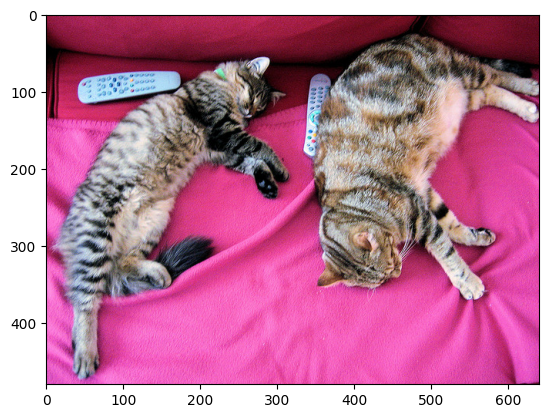

In [9]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

plt.imshow(image)

# List the captions to test against the image
captions = [ "a photo of a cat", "a photo of a dog"]

logits_per_image, probs = infer_model(processor, model, url, captions, device, isImageURL=True)

# print probs of each caption
for i,cap in enumerate(captions):
  print(f"{cap}: {probs[0][i].item():.4f}")


# Now lets upload a sample image from our local machine to drive and run the inference on that

In [10]:
# follow the connect to drive popup instructions
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# uploading personcakefridge.png image to drive (attached with this notebook)

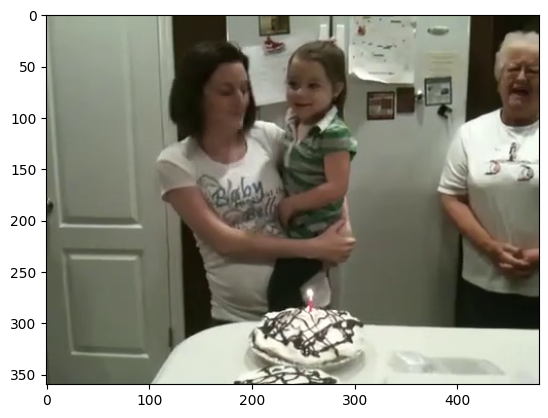

In [11]:
import os # to join the path
IMAGE_FILE_NAME = "personcakefridge.png" # change if you are using some other image.
image = Image.open(os.path.join("/content/drive/MyDrive", IMAGE_FILE_NAME))
plt.imshow(image)

In [12]:
# create 5 sample captions for this image
captions = [
    "a photo of a person holding a baby",
    "a photo of cake on the table",
    "a photo of a family celebrating birthday of a little girl",
    "a photo of a person standing in front of a fridge",
    "a photo of a person cutting the cake"
]

# get inference for given image and captions
logits_per_image, probs = infer_model(processor, model, image, captions, device, isImageURL=False, isImagePath=False)

# print probs of each caption
for i,cap in enumerate(captions):
  print(f"{cap}: [{probs[0][i].item():.4f}]")

# get best caption
best_caption_idx = probs[0].argmax().item()
best_caption = captions[best_caption_idx]
print(f"\n\n\n Best caption: {best_caption} [{probs[0][best_caption_idx]:.4f}]")

a photo of a person holding a baby: [0.0002]
a photo of cake on the table: [0.0020]
a photo of a family celebrating birthday of a little girl: [0.8135]
a photo of a person standing in front of a fridge: [0.0001]
a photo of a person cutting the cake: [0.1843]



 Best caption: a photo of a family celebrating birthday of a little girl [0.8135]
